## Strategies Investigation Notebook
### If possible, I want to centralise all the programs so that they can all run under the same notebook (the way in which the strategies are calculated will all be the same!)

#### So far this program investigates the potential exposure of each strategy via. Monte Carlo Simulation, and also investigates the percentage in growth from the brute force approach for each method!

#### Step 1: Import Modules

In [90]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import scipy
from scipy.stats import chisquare
import sys

#### Step 2: Define PSR Functions: currentExposure, addOn and totalExposure

In [91]:
def currentExposure(mtm):
    return max(0,mtm)


def addOn(notional, addOnFactor):
    return notional*addOnFactor


def totalExposure(mtm, notional, addOnFactor):
    currExp = currentExposure(mtm)
    currAddOn = addOn(notional, addOnFactor)

    return currExp + currAddOn

#### Step 3: Define the 4 different strategies 

In [92]:
def psrBruteForce(position, impacts, addOnFactor, bf_list):
    
    total = 0
    totalMtm = position[0]
    totalNotional = position[1]
    
    total += totalExposure(totalMtm, totalNotional, addOnFactor)
    bf_list.append(total)
    
    for i in range(len(impacts)):

        totalMtm += impacts[i,0]
        totalNotional += impacts[i,1]
        total = totalExposure(totalMtm, totalNotional, addOnFactor)
        bf_list.append(total)
    
    return bf_list


def psrConservative(position, impacts, addOnFactor, cons_list):
    total = 0
    total += totalExposure(position[0], position[1], addOnFactor)
    cons_list.append(total)

    for i in range(len(impacts)):
        total += totalExposure(impacts[i,0], impacts[i,1], addOnFactor)
        cons_list.append(total)

    return cons_list

def psrLinearisation(position, impacts, addOnFactor, lin_list):
    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    lin_list.append(position_exposure)

    for i in range(len(impacts)):
        total += totalExposure(position[0]+impacts[i,0], position[1]+impacts[i,1], addOnFactor) - position_exposure
        
        # We implement the workaround as dicussed below
        lin_list.append(max(0, total))

        # lin_list.append(total)

    return lin_list

def psrAverages(position, impacts, addOnFactor, n, avg_list):
    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    avg_list.append(position_exposure)

    for i in range(len(impacts)):
        total += 1/n*(totalExposure(position[0]+n*impacts[i,0], position[1]+n*impacts[i,1], addOnFactor) - position_exposure)
        avg_list.append(total)

    return avg_list



#### Step 5: Generate the dataset: Baseline Position + Incoming Trades

In [93]:
def get_position_impacts(n):
    
    baseline_position = [100000, 1000000]
    #baseline_position = [63000, 200]
    mtm_notional_matrix = np.zeros((n,2))

    
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(-1000,1000)
        mtm_notional_matrix[i,1] = abs(mtm_notional_matrix[i,0]*10)
        
        #mtm_notional_matrix[i,0] = random.randint(-2000,3000)
        #mtm_notional_matrix[i,1] = random.randint(-1000,1000)
        
    return [baseline_position, mtm_notional_matrix]

#### Step 6: Calculate Mean and Variance of the respective methods by analysing the distribution of values at 100th trade

In [94]:
def get_mean_variance(final_vals, samples):
    
    mu = []
    sigma = []
    std = []

    for i in range(final_vals.shape[0]):
        mu.append(np.sum(final_vals[i,:])/samples)

        current_mu = np.sum(final_vals[i,:])/samples

        std.append(np.std(final_vals[i,:]))

        diff_squared = np.sum((final_vals[i,:] - current_mu) ** 2)
        sigma.append(diff_squared / samples)
        
    return [mu,sigma, std]

#### Step 6a: Clean data by rounding float numbers to 4 decimal places

In [95]:
def remove_decimal_places(my_list):
    new_list = list(np.around(np.array(my_list), 4))
    return new_list

#### Step 7: The big part: Simluate the exposure calculations using Monte Carlo

In [96]:
def exposure_simulation1(n, samples, addon, widget):

    x = np.linspace(0,n+1,n+1)
    final_vals = np.zeros((4,samples))

    fig,axs = plt.subplots(2,2, figsize=(10,8))
    for i in range(samples):
        bf_list = []
        lin_list = []
        cons_list = []
        avg_list = []


        [bl, matrix] = get_position_impacts(n)

        bf_result = psrBruteForce(bl, matrix, addon, bf_list)
        lin_result = psrLinearisation(bl, matrix, addon, lin_list)
        cons_result = psrConservative(bl, matrix, addon, cons_list)
        avg_result = psrAverages(bl, matrix, addon, n, avg_list)
        
        axs[0,0].plot(x,bf_result, c='r', label="Brute Force")
        axs[0,1].plot(x,lin_result, 'g', label="Linearisation")
        axs[1,0].plot(x,cons_result, 'b', label="Conservative")
        axs[1,1].plot(x,avg_result, 'y', label="Averages")
        

        final_vals[0,i] = bf_list[-1]
        final_vals[1,i] = lin_list[-1]
        final_vals[2,i] = cons_list[-1]
        final_vals[3,i] = avg_list[-1]


    axs[0,0].set_xlabel("Trade Number")
    axs[0,0].set_ylabel("Exposure")

    axs[1,0].set_xlabel("Trade Number")
    axs[1,0].set_ylabel("Exposure")

    axs[0,1].set_xlabel("Trade Number")
    axs[0,1].set_ylabel("Exposure")

    axs[1,1].set_xlabel("Trade Number")
    axs[1,1].set_ylabel("Exposure")
    
    axs[0,0].set_title("Brute Force")
    axs[0,1].set_title("Linearisation")
    axs[1,0].set_title("Conservative")
    axs[1,1].set_title("Averages")

    plt.show()
    
    if widget == False:
        return final_vals
    else:
        return None    


#### Step 8: Run the functions above, analyse the graphs, and inspect mean and variance of each method

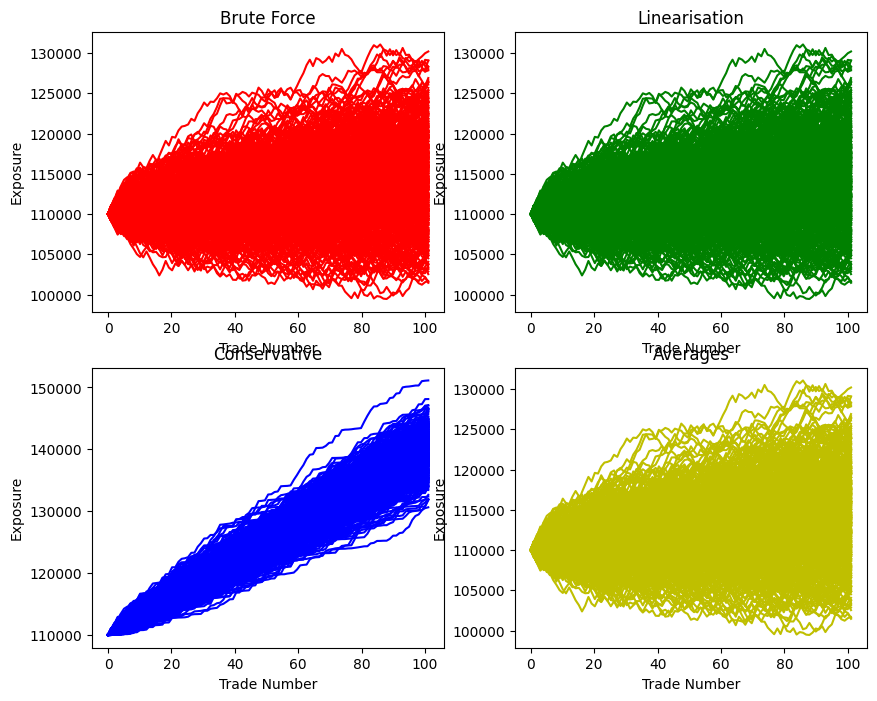

Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]
Values for mu:  [114865.799, 114865.799, 139825.149, 114865.799]
Values for sigma:  [30211007.2395, 30211007.2395, 9859100.4917, 30211007.2395]
Values for standard deviation:  [5496.4541, 5496.4541, 3139.9205, 5496.4541]


In [97]:
samples = 500
n = 100
addOnFactor = 0.01

final_vals = exposure_simulation1(n, samples, addOnFactor, False)

[mu,sigma,std] = get_mean_variance(final_vals, samples)

#print("Final Values: ", final_vals)

print("Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]")
print("Values for mu: ", remove_decimal_places(mu))
print("Values for sigma: ", remove_decimal_places(sigma))
print("Values for standard deviation: ", remove_decimal_places(std))

#### INTERACT
##### Toggle the sliders below to investigate the growth rates yourself!

In [98]:
widgets.interact(exposure_simulation1, 
         n = widgets.IntSlider(min = 20 , max = 400, step = 1, value=100, description="No. of Trades"),
         samples = widgets.IntSlider(min=0,max=5000,step=20,value=200,description="No. of Samples"),
         addon = widgets.FloatSlider(min=0, max = 1, value=0.01, step = 0.01, description="addOnFactor"),
         widget = True,
)

interactive(children=(IntSlider(value=100, description='No. of Trades', max=400, min=20), IntSlider(value=200,…

<function __main__.exposure_simulation1(n, samples, addon, widget)>

In [99]:
def simulation_exposure_growth(n, samples, addon, lin=True, cons=False, avg=False):


    bf_exposure_for_trade_i = []
    cons_exposure_for_trade_i = []
    lin_exposure_for_trade_i = []
    avg_exposure_for_trade_i = []

    for i in range(1,n):
        
        bf_list = []
        cons_list = []
        lin_list = []
        avg_list = []

        [bl, matrix] = get_position_impacts(i)

        bf_result = psrBruteForce(bl, matrix, addon, bf_list)
        lin_result = psrLinearisation(bl, matrix, addon, lin_list)
        cons_result = psrConservative(bl, matrix, addon, cons_list)
        avg_result = psrAverages(bl, matrix, addon, n, avg_list)


        bf_exposure_for_trade_i.append(bf_result[-1])
        cons_exposure_for_trade_i.append(cons_result[-1])
        lin_exposure_for_trade_i.append(lin_result[-1])
        avg_exposure_for_trade_i.append(avg_result[-1])


    diff_cons = [(cons_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_lin = [(lin_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_avg = [(avg_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
        
        
        # We only want to take the last value of each iteration, this is the final exposure for each trade number


    x = np.arange(1,n)

    plt.figure(figsize=(7, 3))
    plt.grid(True)

    if lin == True:
        plt.plot(x[int(n/100):],diff_lin[int(n/100):],'r', label="Linearisation")
    
    if cons == True:
        plt.plot(x,diff_cons,'b', label="Conservative")

    if avg == True:
        plt.plot(x,diff_avg,'g', label="Averages")

    plt.xlabel("# of trades")
    plt.ylabel("% Diff. from Brute Force")
    plt.legend()
    plt.show()

        

#### Run the code using the ipywidgets module

In [100]:
widgets.interact(simulation_exposure_growth, 
         n = widgets.Play(min = 20 , max = 800, step = 20, interval=200),
         samples = widgets.IntSlider(min=0,max=100000,step=500,value=1000,description="samples"),
         addon = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
)

interactive(children=(Play(value=20, description='n', interval=200, max=800, min=20, step=20), IntSlider(value…

<function __main__.simulation_exposure_growth(n, samples, addon, lin=True, cons=False, avg=False)>